## Test UNIQUE with a Random Forest regressor on the California Housing dataset

In this Notebook, we showcase how to use UNIQUE to assess the uncertainty quantification methods for a random forest (RF) regressor and a multilayer perceptron (MLP), both trained on the [California Housing dataset](https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html) provided by `scikit-learn` package.

As uncertainty quantification methods based on models, we derive the variance of the predictions from 8 trees for the RF and the Monte Carlo dropout for the MLP.


The UNIQUE pipeline has been set with the following parameters:
- Regression Task
- UQ metrics: 
    - Ensemble Variance (from the property model output)
    - ManhattanDistance
    - EuclideanDistance
- Error model: 
    - UniqueRandomForestRegressor
    - UniqueLASSO

## UNIQUE Input data generation

In [1]:
import json
import os
import yaml
from pathlib import Path

import numpy as np
import pandas as pd

# Install torch to prepare the California Housing data
try:
    import torch
except ImportError:
    # Replace with conda if mamba not available
    # %mamba install pytorch::pytorch -y
    %pip install torch --index-url https://download.pytorch.org/whl/cpu

from unique import Pipeline

# Set the project's directory
PROJECT_PATH = os.environ.get("PROJECT_PATH", os.path.abspath("")) # ALTERNATIVELY, REPLACE `os.path.abspath("")` WITH YOUR PATH TO THE SYNTHETIC EXAMPLE FOLDER
%cd $PROJECT_PATH

from preparation import SyntheticDataExamplePreparation

/home/huynhmia/PKS/unique/notebooks/california_housing


In [2]:
unique_input_data_path = f'{PROJECT_PATH}/unique_input_data.json'

s = SyntheticDataExamplePreparation()

if Path(unique_input_data_path).is_file():
    print('UNIQUE input data already generated.')
else:
    train_indices, val_indices, test_indices, \
    X_train, X_val, X_test, y_train, y_val, y_test, \
    rf_all_predictions, rf_variances, \
    mlp_all_predictions, mlp_variances = s.run()
    
    unique_dict = {
        'ID': np.concatenate([train_indices, val_indices, test_indices]).tolist(),
        'feature': [X_train[i, :].tolist() for i in range(X_train.shape[0])] +
                    [X_val[i, :].tolist() for i in range(X_val.shape[0])] +
                    [X_test[i, :].tolist() for i in range(X_test.shape[0])],
        'label': np.concatenate([y_train, y_val, y_test]).tolist(),
        'which_set': ['TRAIN'] * len(train_indices) +
                    ['CALIBRATION'] * len(val_indices) +
                    ['TEST'] * len(test_indices),
        'rf_predictions': rf_all_predictions.tolist(),
        'rf_variances': rf_variances,
        'mlp_predictions': mlp_all_predictions.detach().squeeze().numpy().tolist(),
        'mlp_variances': mlp_variances.tolist()
    }


    with open(unique_input_data_path, 'w') as f:
        json.dump(unique_dict, f)

UNIQUE input data already generated.


## UNIQUE Pipeline

To evaluate the UQ methods of interest, including an additional set of UQ methods generated by the UNIQUE pipeline, you can run the `fit()` method of the pipeline. This will allow you to assess their performance using three main UQ evaluation types: Ranking, Proper scoring rules, and Calibration curves.

The summary tables provide scores for each UQ method based on a set of UQ evaluation metrics that are indicative of each evaluation type. The UQ method with the highest score is highlighted in green, indicating it as the best performing method.

Following the summary tables, you will find individual plots showcasing the performance of the best UQ methods.

Additionally, you can explore the summary plots generated for all the evaluated UQ methods, providing a comprehensive overview of their performance.


In [3]:
def overwrite_paths(yaml_file: str, project_path: str, input_data_file: str = "unique_input_data.json"):
	"""Given a yaml UNIQUE config file, overwrite the `data_path` and `output_path` fields."""
	# Use ruamel.yaml to preserve comments
	from ruamel.yaml import YAML
	yaml = YAML()

	# Read
	with open(yaml_file, "r") as f:
		# If you want the equivalent of yaml.safe_load use `typ="safe"`
		config = yaml.load(f) # defaults to `typ="rt"` (round-trip) argument. 

	# Overwrite
	config["data_path"] = os.path.join(project_path, input_data_file)
	config["output_path"] = os.path.join(project_path, "output")

	# Save
	with open(yaml_file, "w") as f:
		yaml.dump(config, f)

[19:17:18] | [UNIQUE - INFO]: ************************ UNIQUE - INITIALIZING PIPELINE ************************
[19:17:18] | [UNIQUE - INFO]: Loaded Pipeline configuration from: 'config_mlp.yaml'
[19:17:18] | [UNIQUE - INFO]: Loading data from 'unique_input_data.json'...
[19:17:18] | [UNIQUE - INFO]: Dataset with 20640 entries correctly loaded.
[19:17:18] | [UNIQUE - INFO]: UQ inputs initialization...
[19:17:18] | [UNIQUE - INFO]: UQ inputs summary: 
                                  1. [Data-Based Feature] Column: 'feature' | UQ methods to compute: Manhattan Distance, Euclidean Distance
                                  2. [Model-Based Feature] Column: 'mlp_variances' | UQ methods to compute: Ensemble Variance
[19:17:18] | [UNIQUE - INFO]: Selected error model(s): 
                                  1. UniqueRandomForestRegressor
                                  2. UniqueLASSO
[19:17:18] | [UNIQUE - INFO]: ************************ UNIQUE - COMPUTING UQ METHODS *************************

,UQ Method,Subset,AUC Difference: UQ vs. True Error,Spearman Correlation,Performance Drop: High UQ vs. Low UQ (3-Bins),Performance Drop: All vs. Low UQ (10-Bins),Performance Drop: High UQ vs. Low UQ (10-Bins),Increasing Coefficient,Decreasing Coefficient,Performance Drop: All vs. Low UQ (3-Bins)
0,ManhattanDistance[feature],TEST,2.744,0.402,1.179,1.073,1.387,0.149,4.468,1.065
1,EuclideanDistance[feature],TEST,2.589,0.445,1.190,1.075,1.393,0.133,4.468,1.070
2,EnsembleVariance[mlp_variances],TEST,2.586,0.648,1.216,1.002,1.368,0.896,4.126,1.075
3,"Diff5NN[ManhattanDistance[feature], EnsembleVariance[mlp_variances]]",TEST,3.344,0.437,1.148,1.049,1.352,0.609,4.468,1.050
4,"Diff5NN[ManhattanDistance[feature], predictions]",TEST,6.284,-0.011,0.996,1.001,1.010,2.644,1.923,0.996
5,"Diff5NN[EuclideanDistance[feature], EnsembleVariance[mlp_variances]]",TEST,3.354,0.435,1.146,1.046,1.341,0.515,4.468,1.050
6,"Diff5NN[EuclideanDistance[feature], predictions]",TEST,6.192,-0.007,0.998,1.007,1.027,2.649,2.193,0.996
7,Dist2Var[ManhattanDistance[feature]],TEST,2.744,0.402,1.179,1.073,1.387,0.149,4.468,1.065
8,Dist2Var[EuclideanDistance[feature]],TEST,2.589,0.445,1.190,1.075,1.393,0.133,4.468,1.070
9,SumOfVariances[Dist2Var[EuclideanDistance[feature]]],TEST,1.729,0.706,1.233,1.105,1.503,0.001,4.468,1.093


,UQ Method,Subset,MACE,RMSCE
0,EnsembleVariance[mlp_variances],TEST,0.394,0.494
1,Dist2Var[ManhattanDistance[feature]],TEST,0.310,0.384
2,Dist2Var[EuclideanDistance[feature]],TEST,0.298,0.370
3,SumOfVariances[Dist2Var[EuclideanDistance[feature]]],TEST,0.392,0.492
4,UniqueRandomForestRegressor[feature+UQmetrics+predictions](l1),TEST,0.400,0.502
5,UniqueRandomForestRegressor[UQmetrics+predictions](l1),TEST,0.400,0.502
6,UniqueRandomForestRegressor[transformedUQmetrics+predictions](l1),TEST,0.400,0.502
7,UniqueLASSO[feature+UQmetrics+predictions](l1),TEST,0.400,0.502
8,UniqueLASSO[UQmetrics+predictions](l1),TEST,0.400,0.502
9,UniqueLASSO[transformedUQmetrics+predictions](l1),TEST,0.400,0.502


,UQ Method,Subset,NLL,CRPS,CheckScore,IntervalScore
0,EnsembleVariance[mlp_variances],TEST,6.295,49.772,25.132,228.391
1,Dist2Var[ManhattanDistance[feature]],TEST,5.715,44.431,22.436,193.064
2,Dist2Var[EuclideanDistance[feature]],TEST,5.714,44.427,22.434,193.076
3,SumOfVariances[Dist2Var[EuclideanDistance[feature]]],TEST,5.745,43.912,22.173,202.177
4,UniqueRandomForestRegressor[feature+UQmetrics+predictions](l1),TEST,39.787,68.620,34.412,633.015
5,UniqueRandomForestRegressor[UQmetrics+predictions](l1),TEST,39.812,68.621,34.413,633.054
6,UniqueRandomForestRegressor[transformedUQmetrics+predictions](l1),TEST,39.800,68.620,34.412,633.032
7,UniqueLASSO[feature+UQmetrics+predictions](l1),TEST,39.784,68.619,34.412,633.006
8,UniqueLASSO[UQmetrics+predictions](l1),TEST,39.786,68.619,34.412,632.999
9,UniqueLASSO[transformedUQmetrics+predictions](l1),TEST,39.784,68.619,34.412,632.999


[19:23:22] | [UNIQUE - INFO]: Summary evaluation tables saved to: /home/huynhmia/PKS/unique/notebooks/california_housing/output/summary.
[19:23:32] | [UNIQUE - INFO]: Generating summary plots...
[19:23:53] | [UNIQUE - INFO]: Summary plots saved to: /home/huynhmia/PKS/unique/notebooks/california_housing/output/summary.
[19:23:53] | [UNIQUE - INFO]: Summary of best UQ method for each UQ evaluation type:
                                  1. [TEST] RankingBasedEvaluation: UniqueRandomForestRegressor[feature+UQmetrics+predictions](l1)
                                  2. [TEST] CalibrationBasedEvaluation: Dist2Var[EuclideanDistance[feature]]
                                  3. [TEST] ProperScoringRulesEvaluation: Dist2Var[EuclideanDistance[feature]]
[19:23:53] | [UNIQUE - INFO]: ********************************* UNIQUE - END *********************************
[19:23:53] | [UNIQUE - INFO]: Time elapsed: 00h:06m:35s


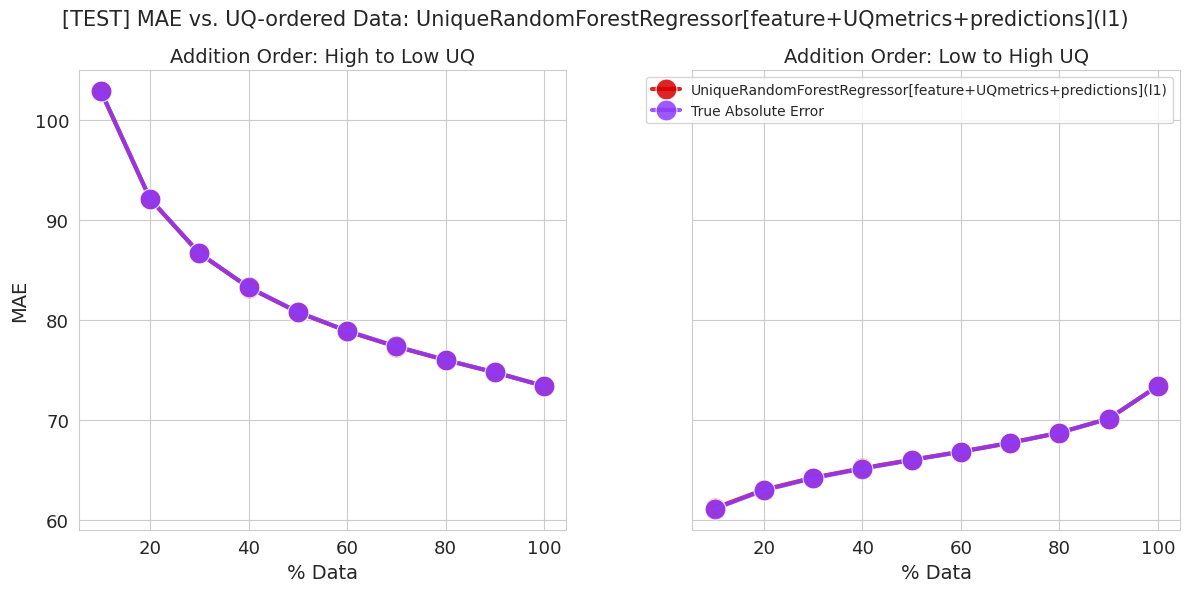

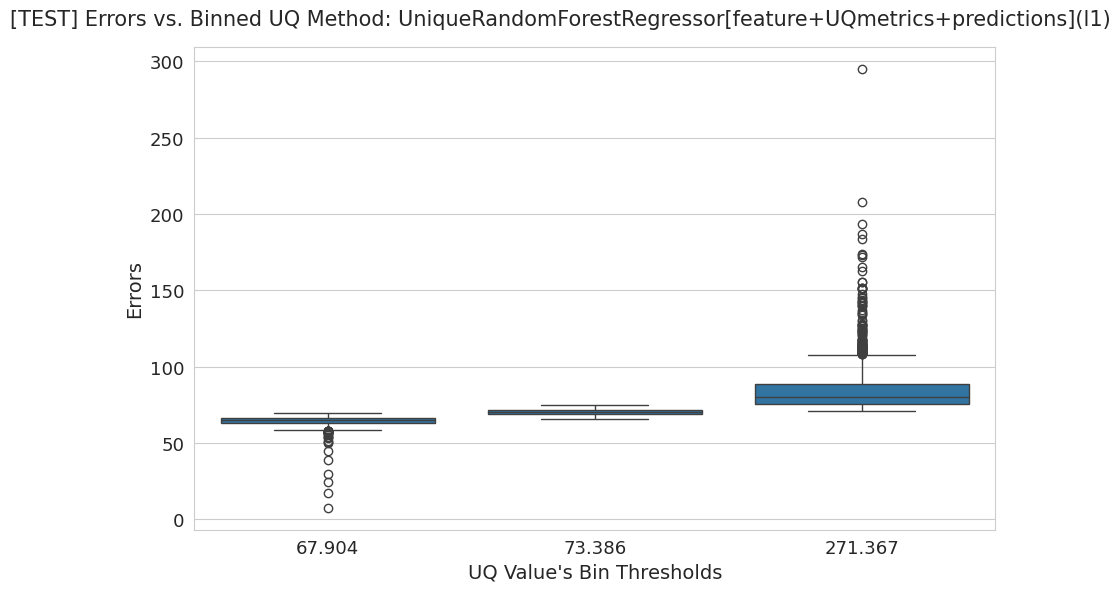

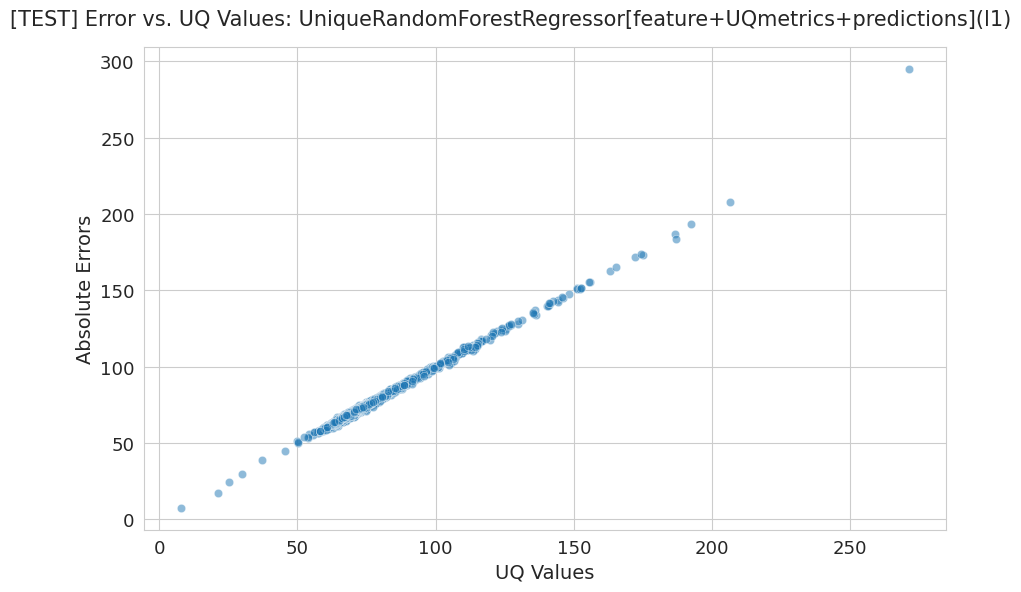

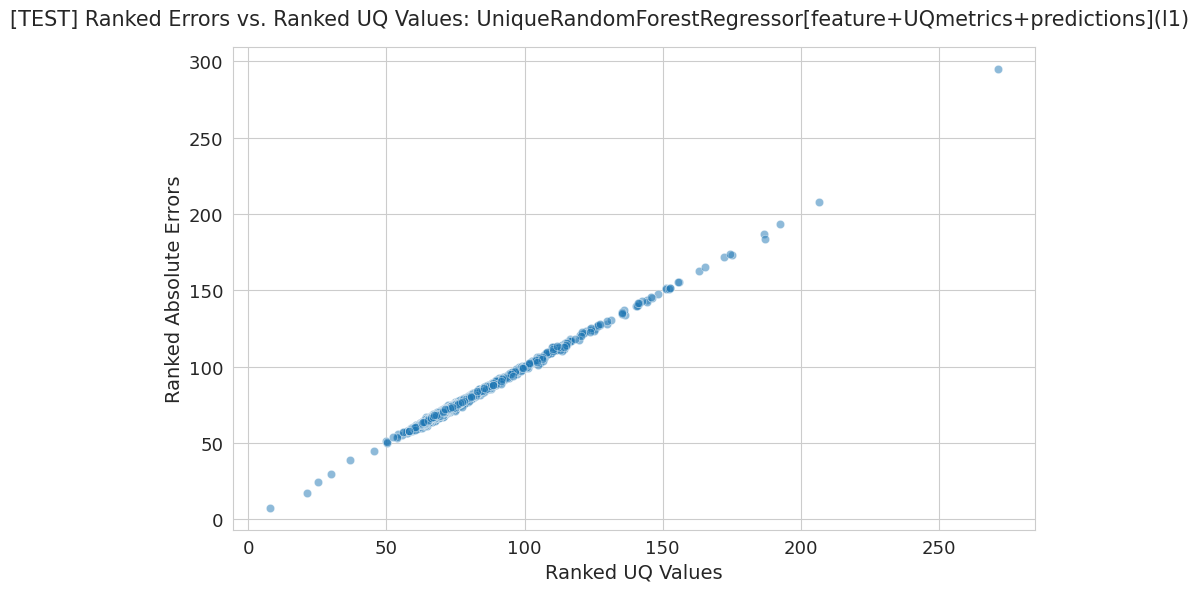

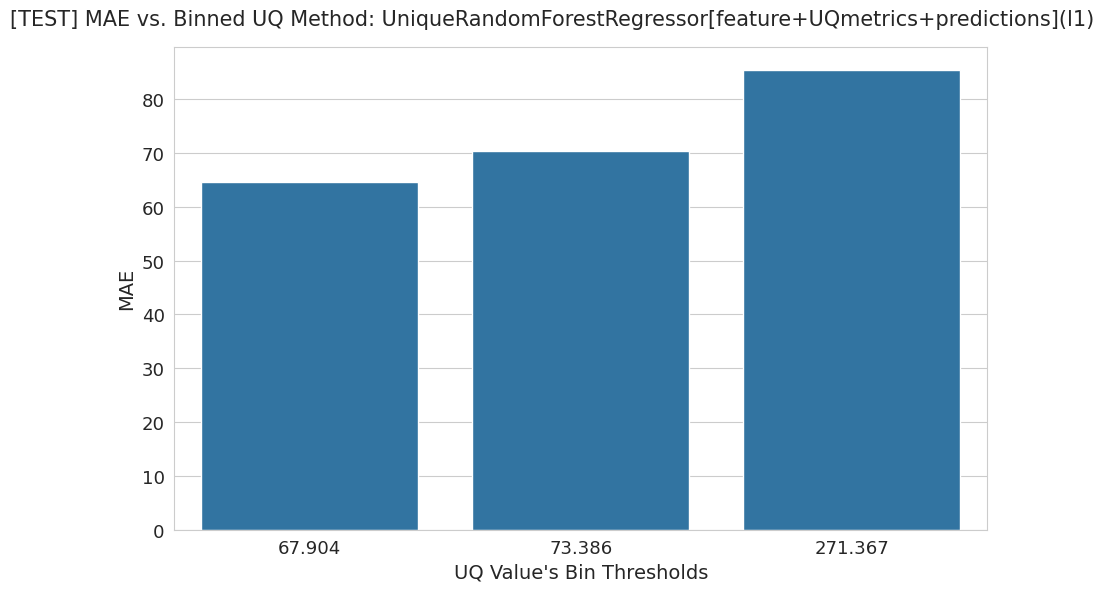

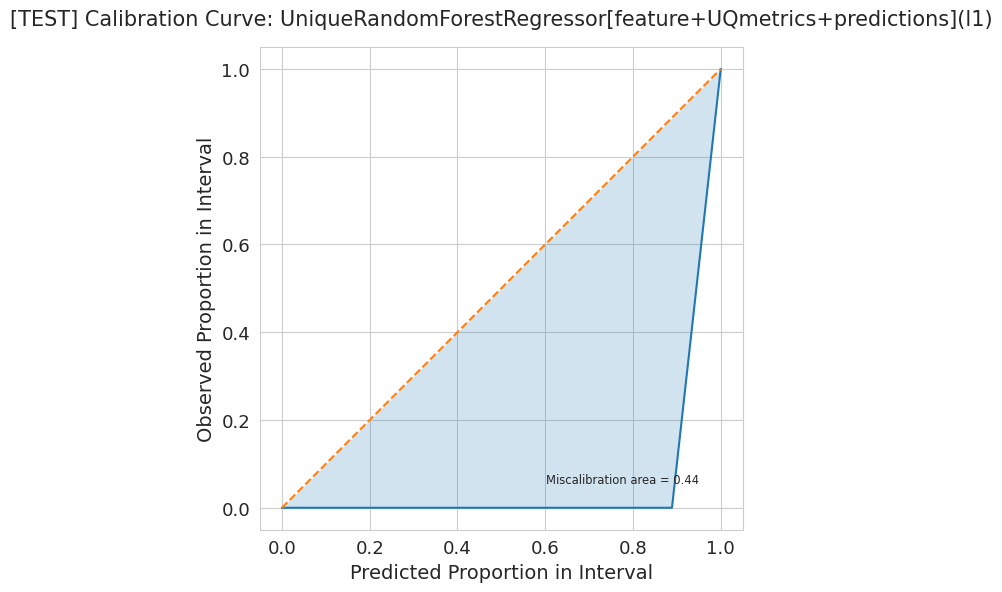

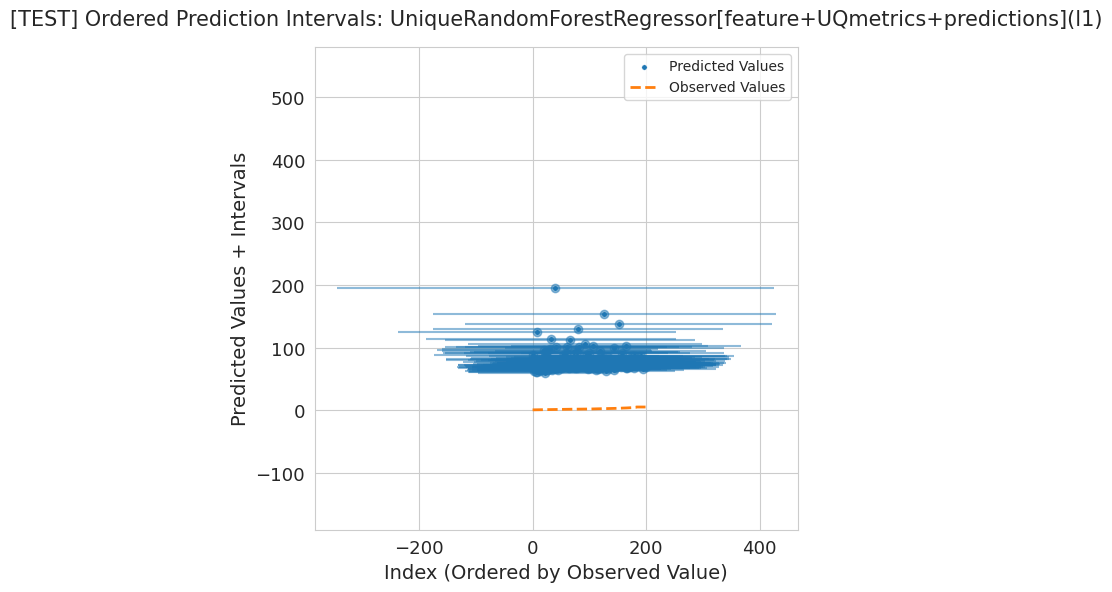

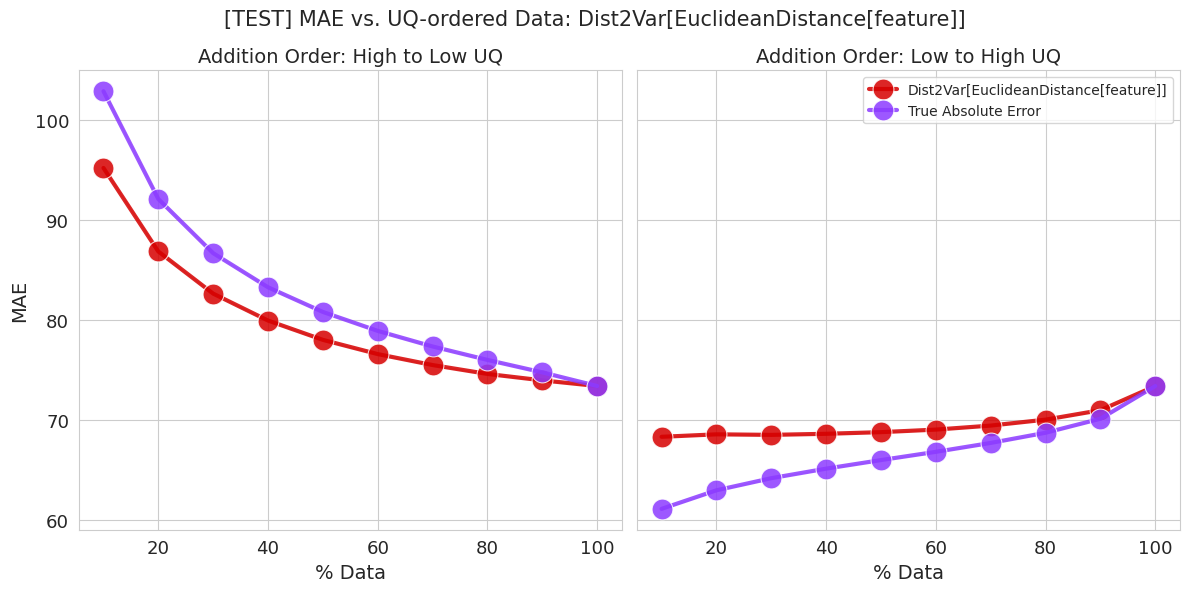

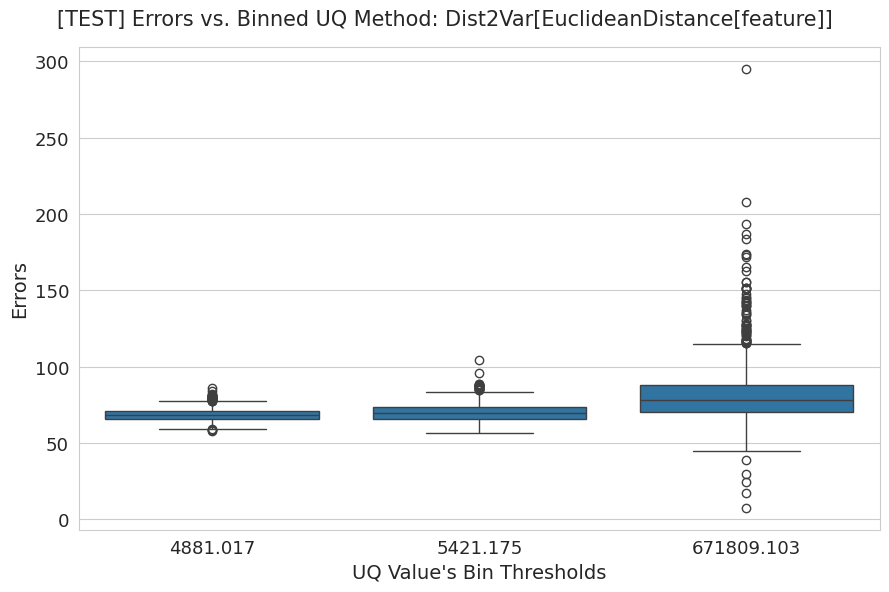

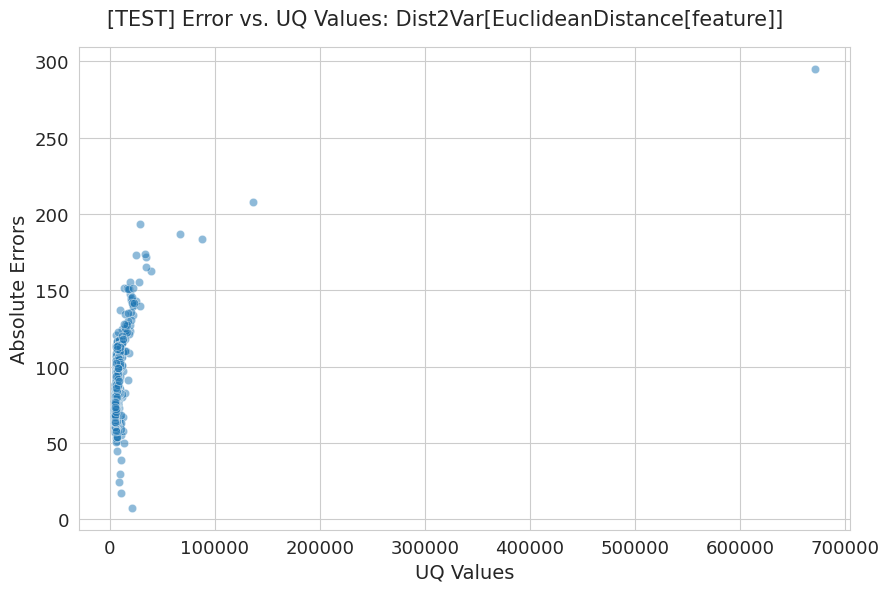

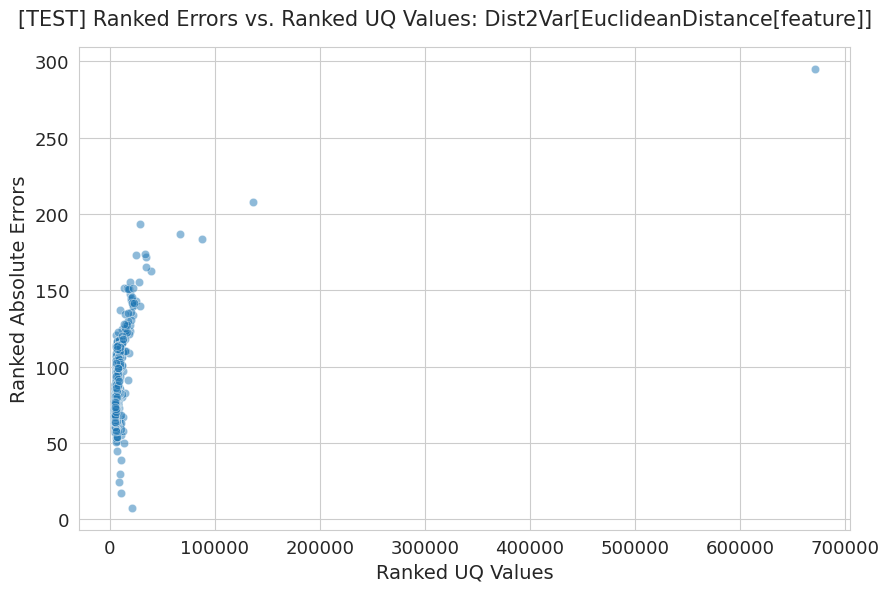

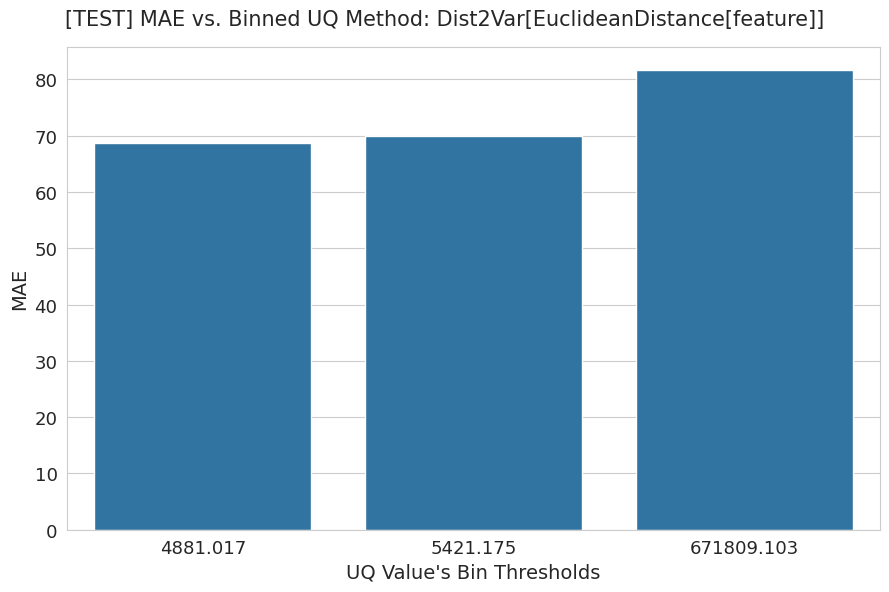

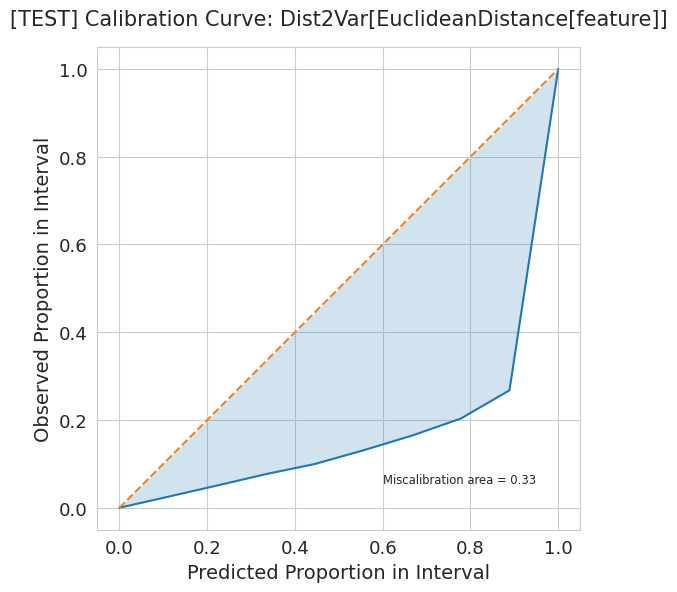

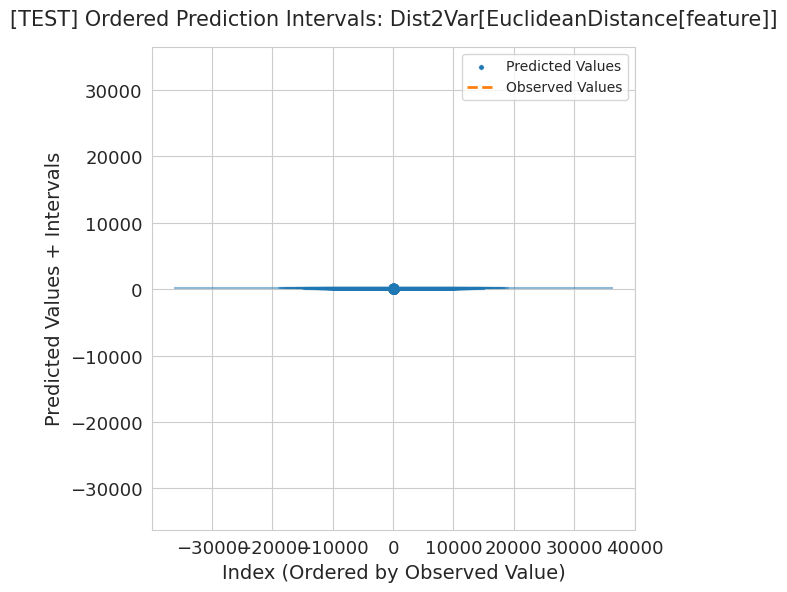

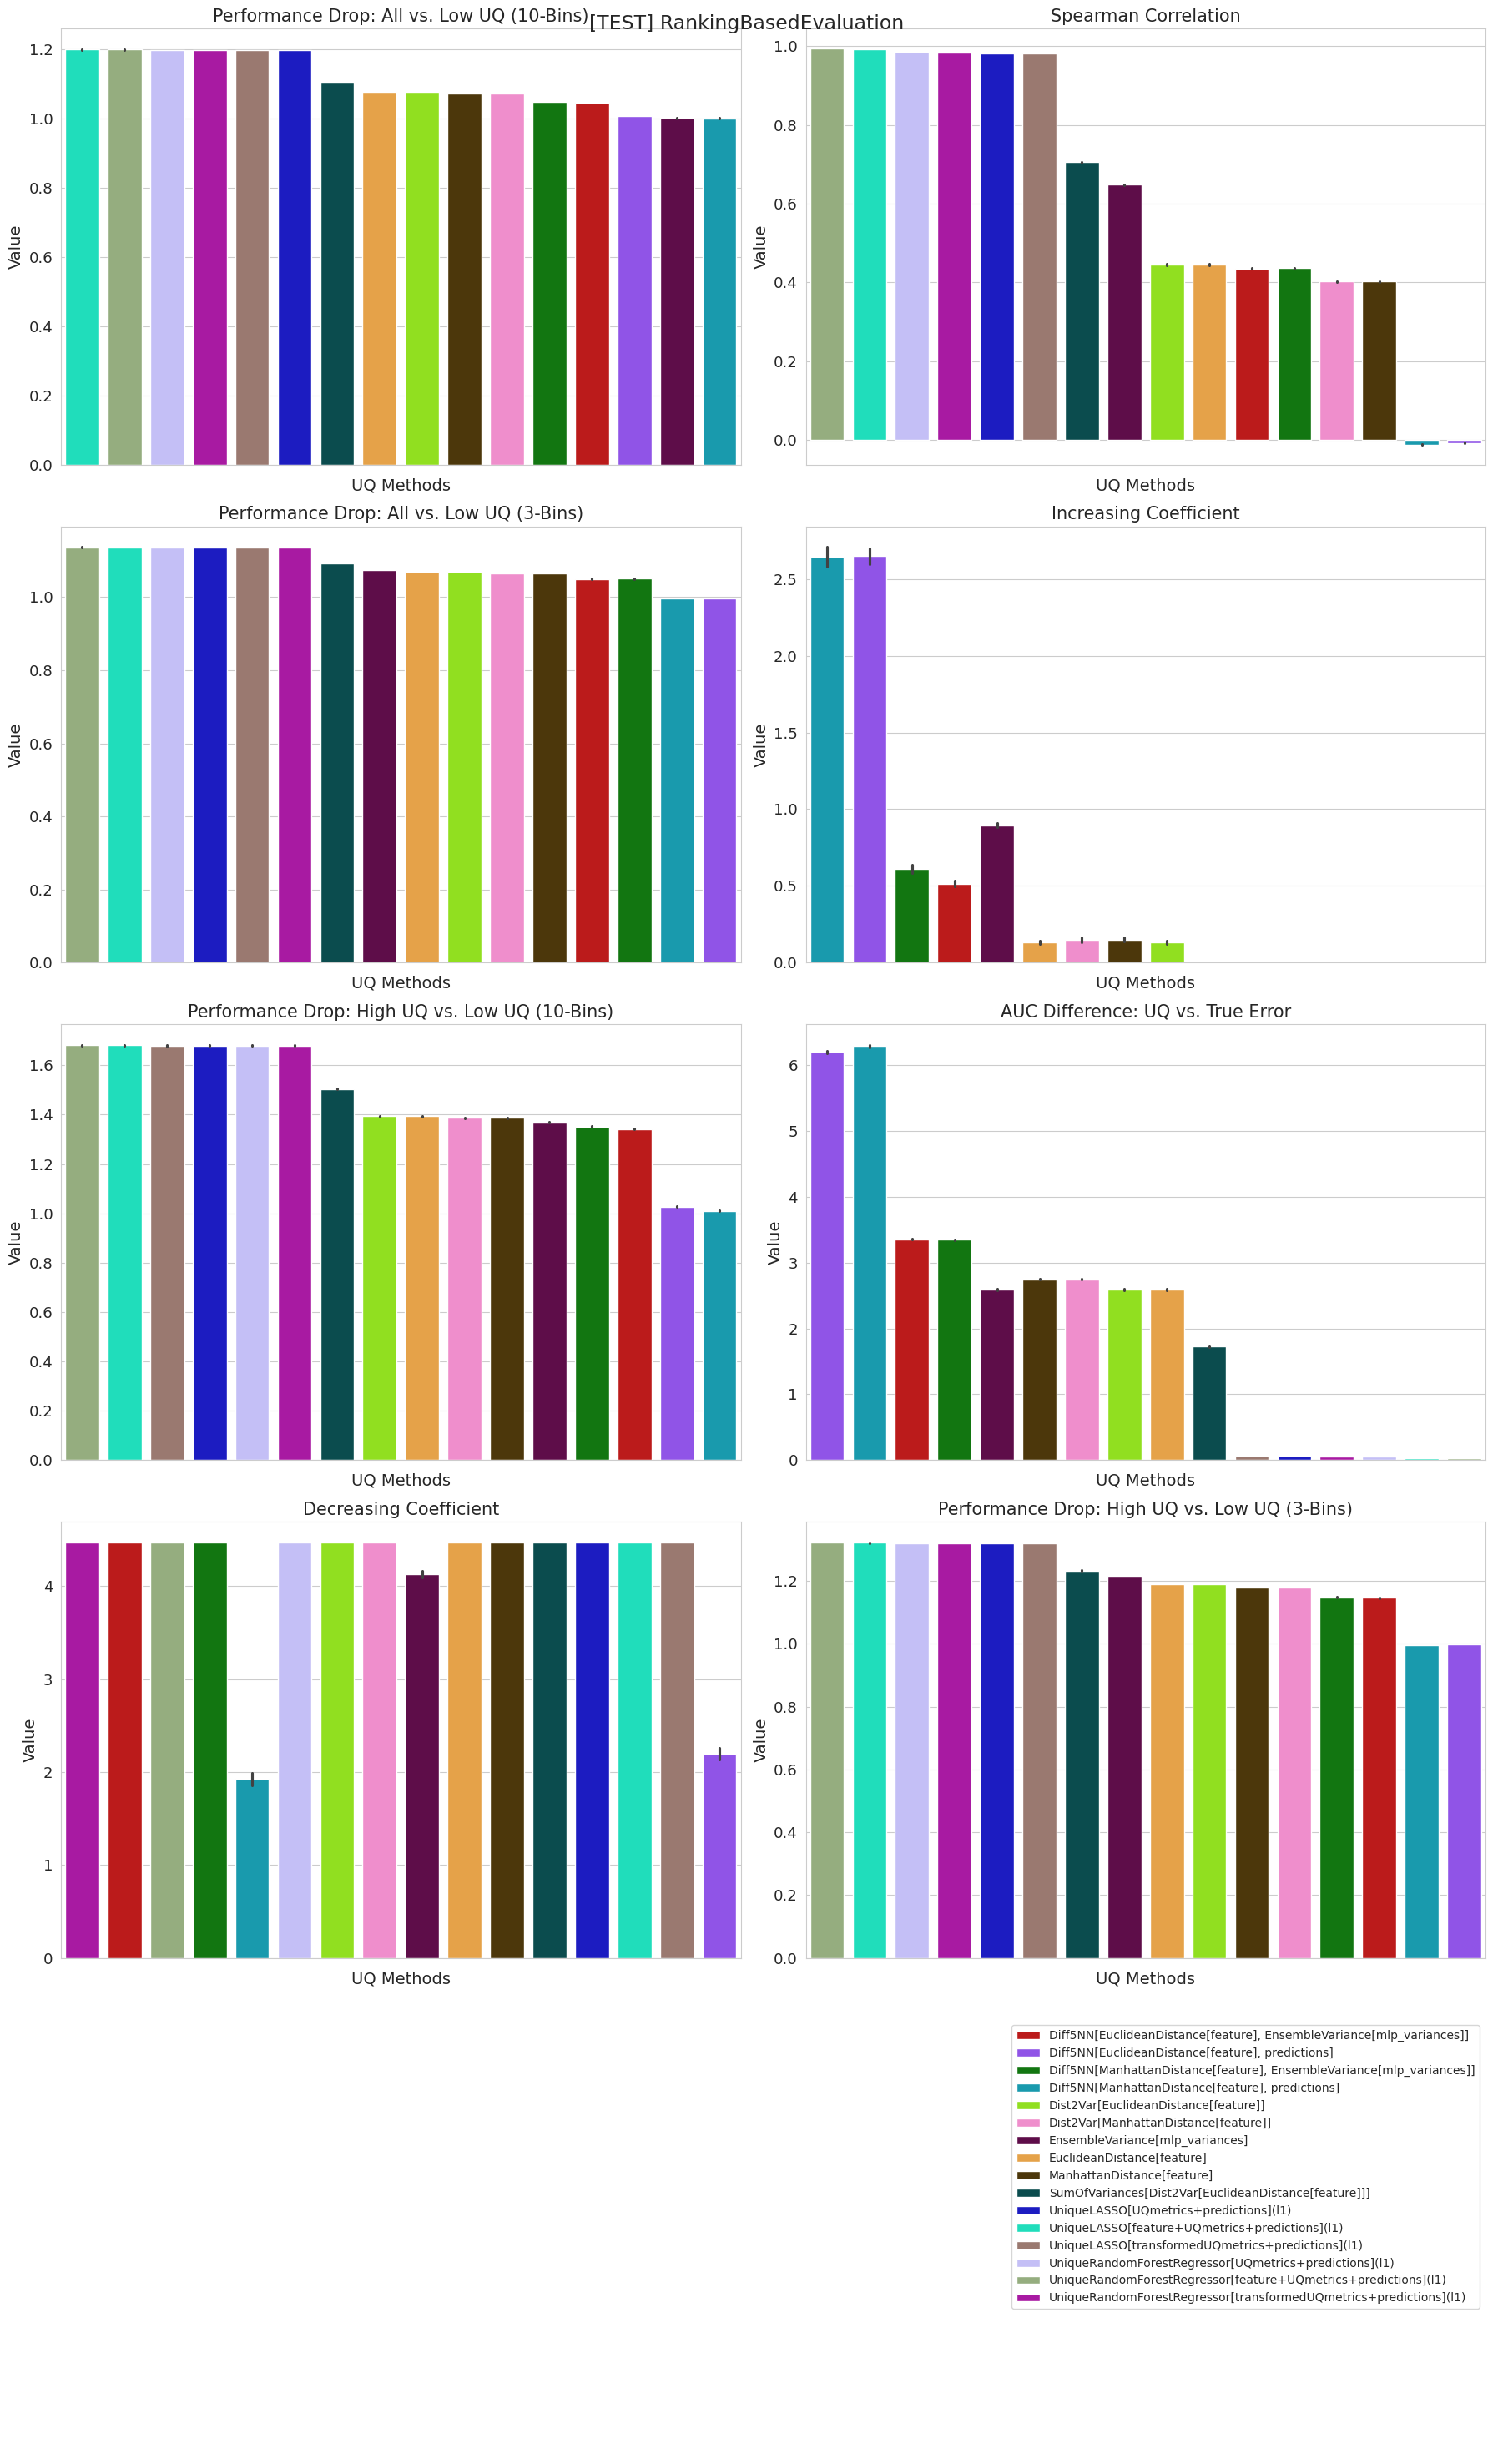

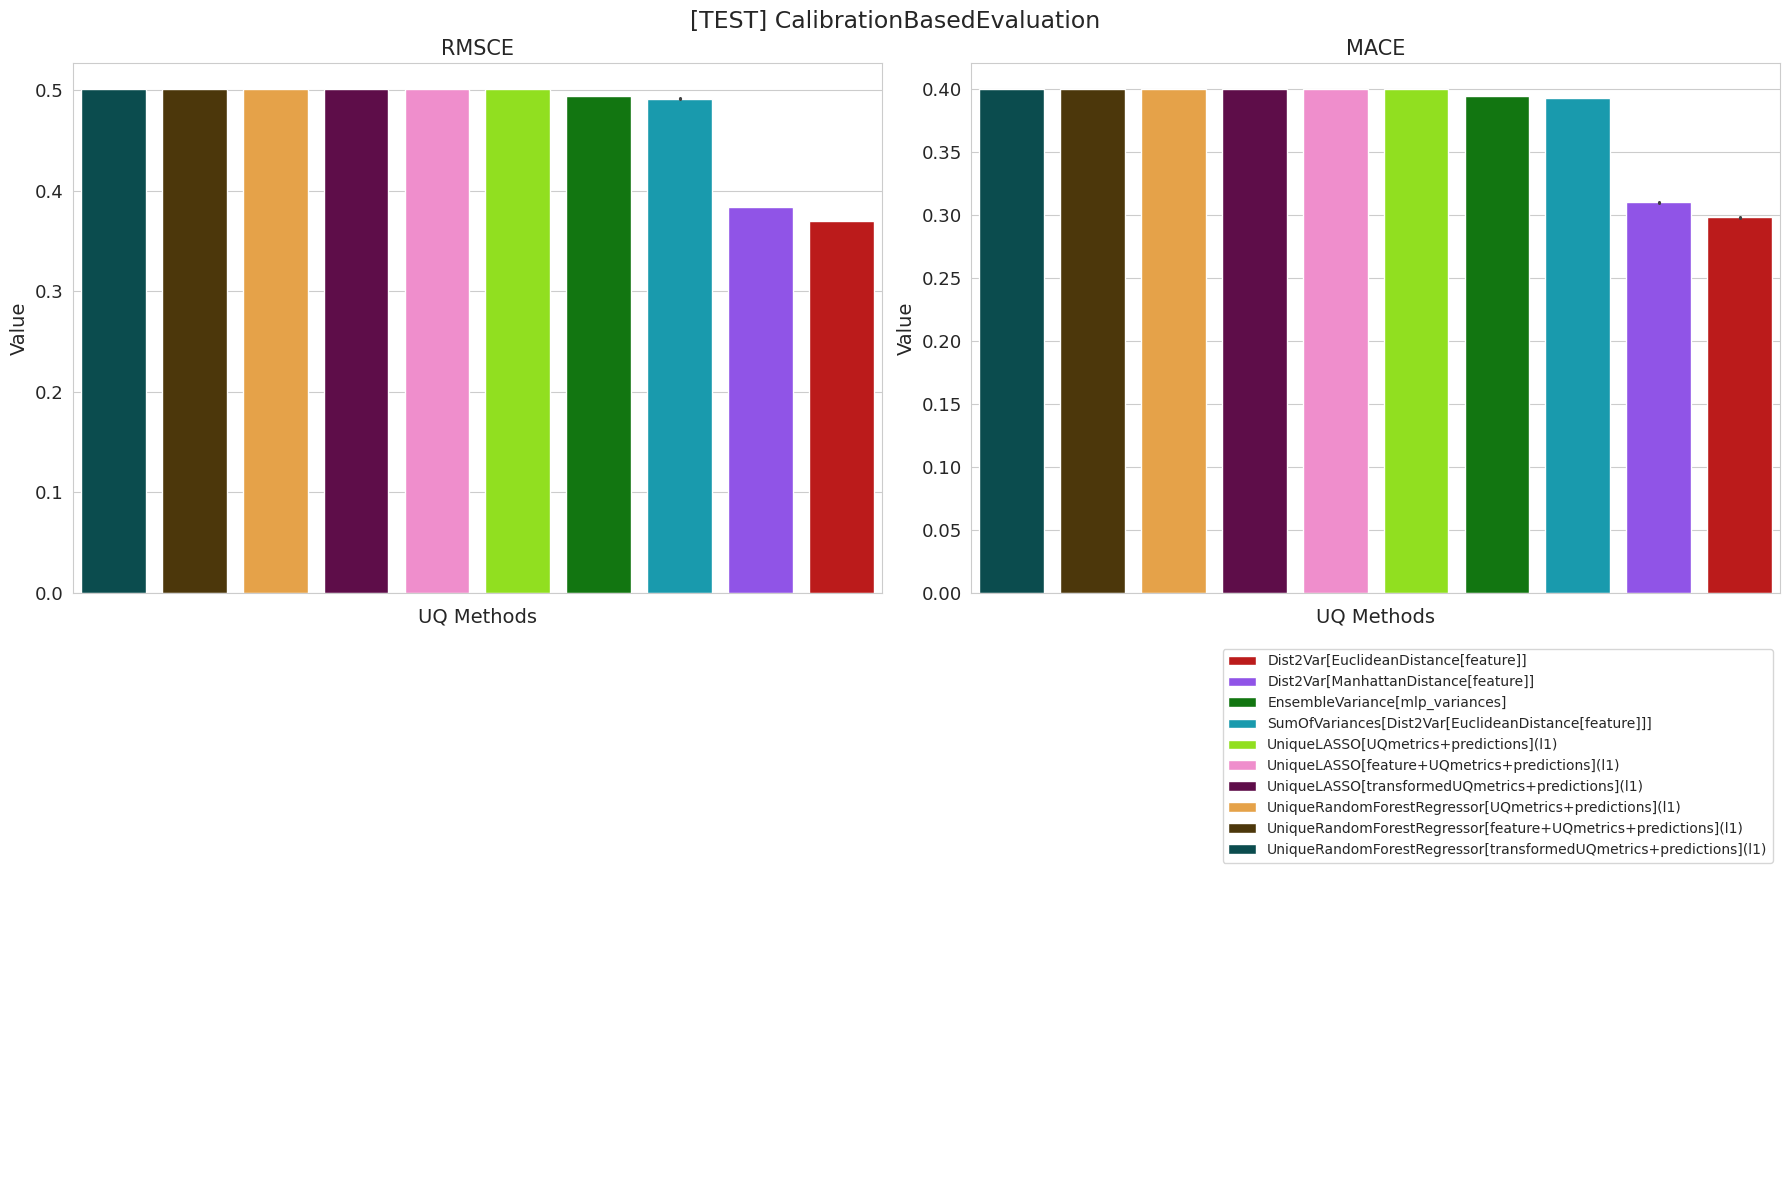

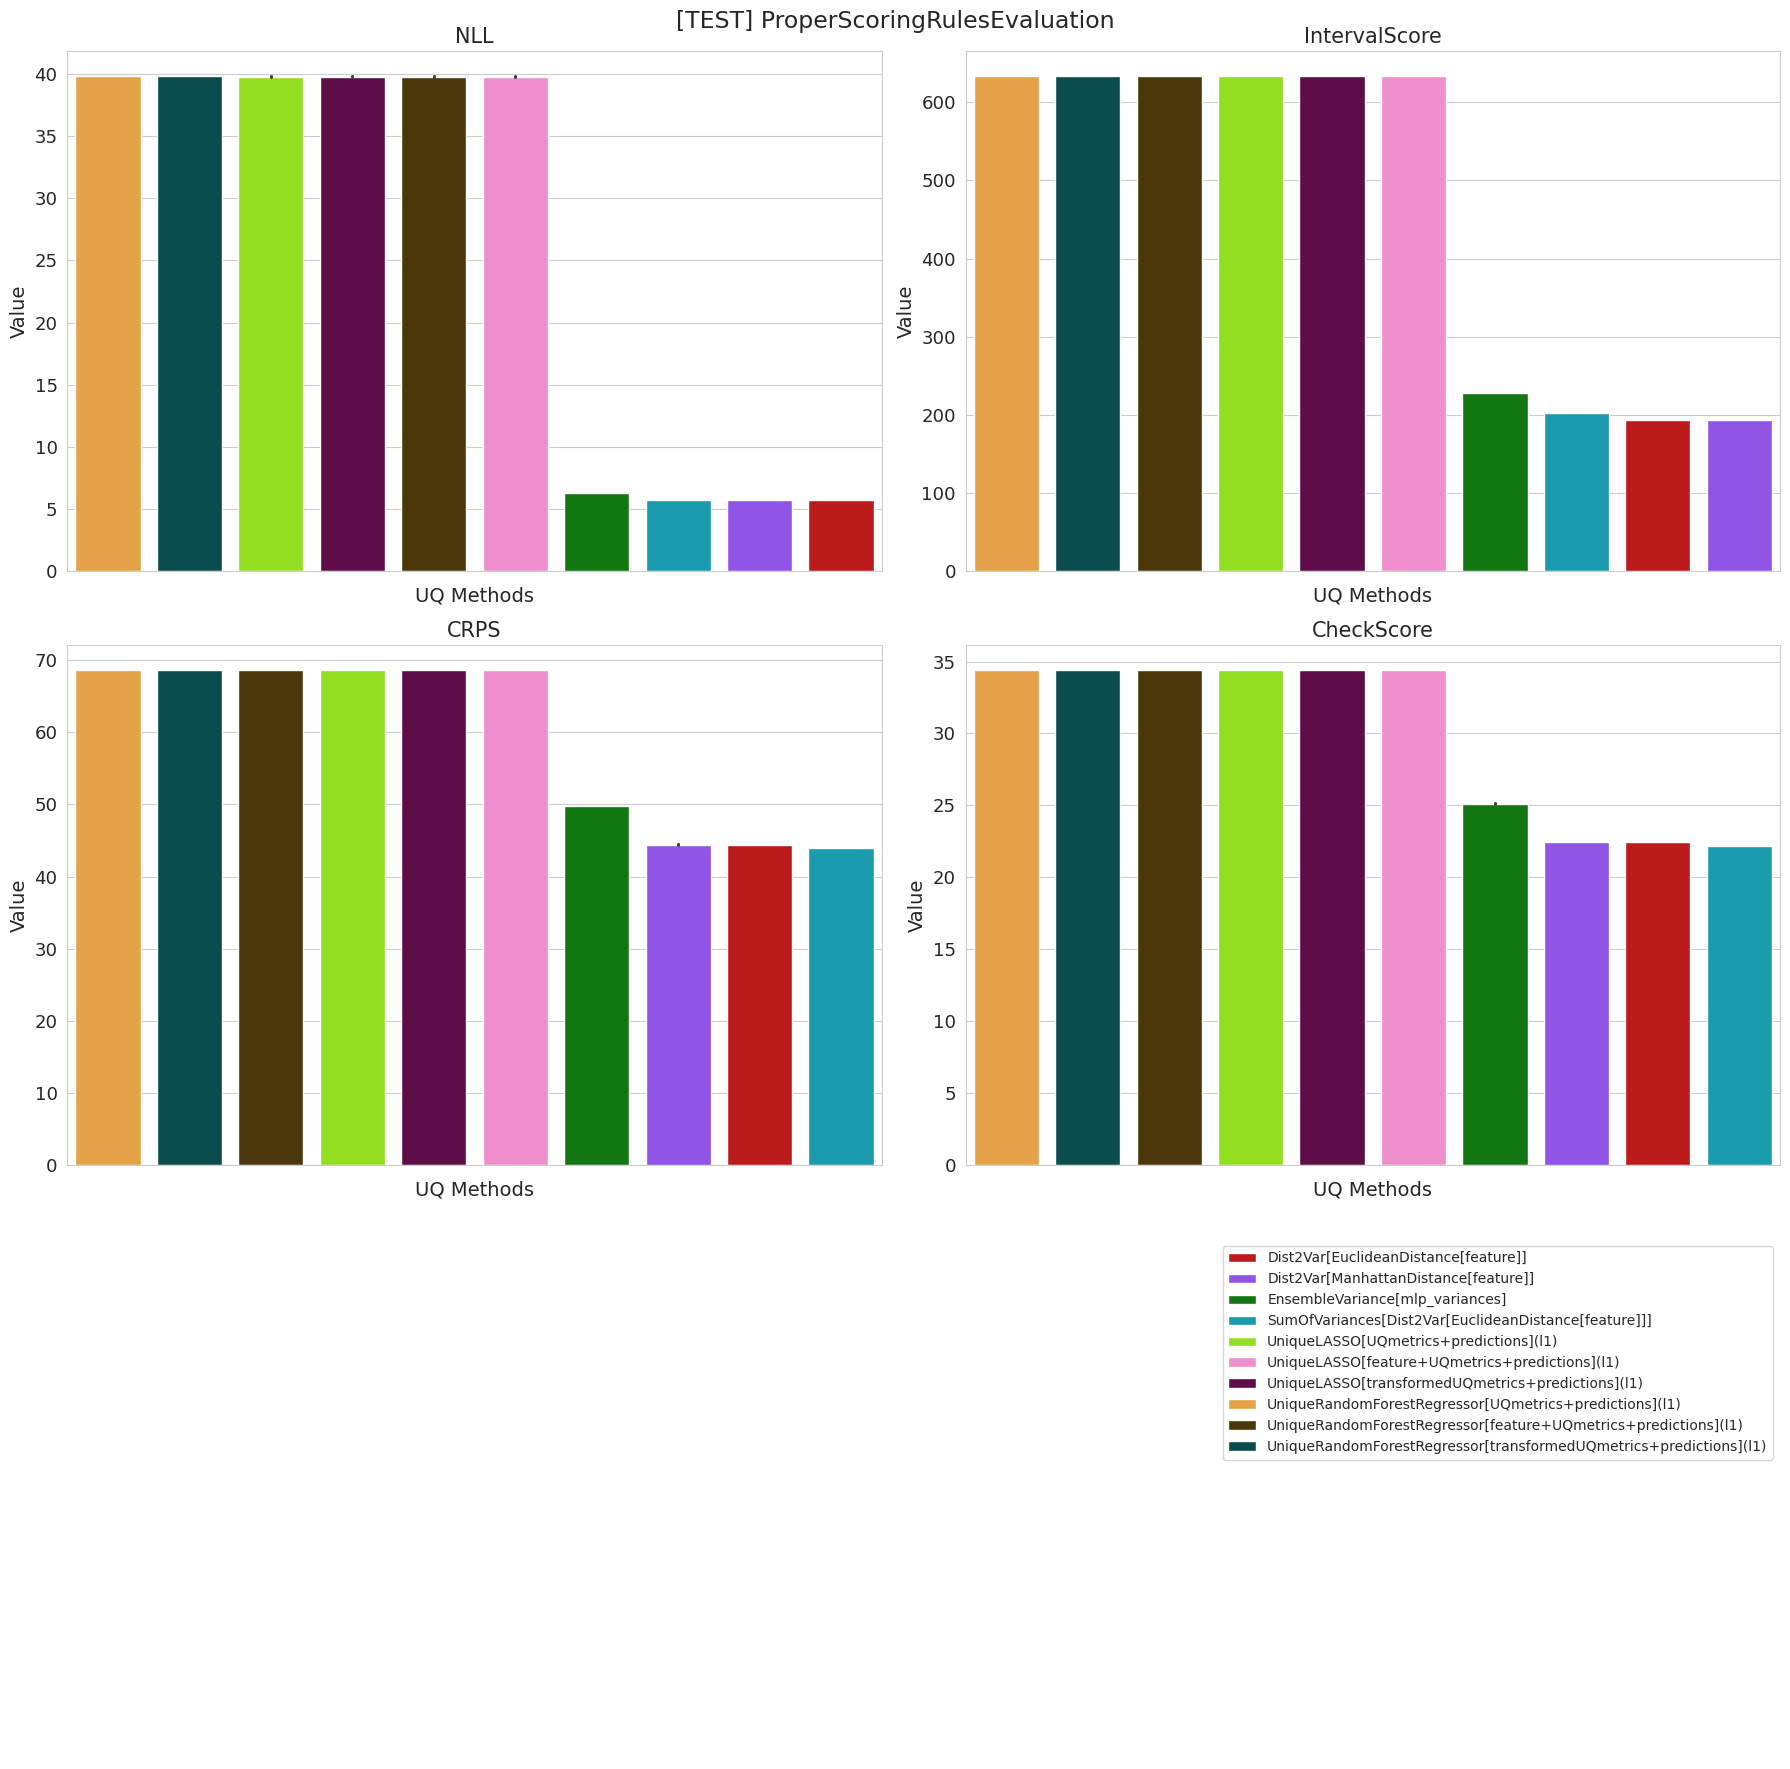

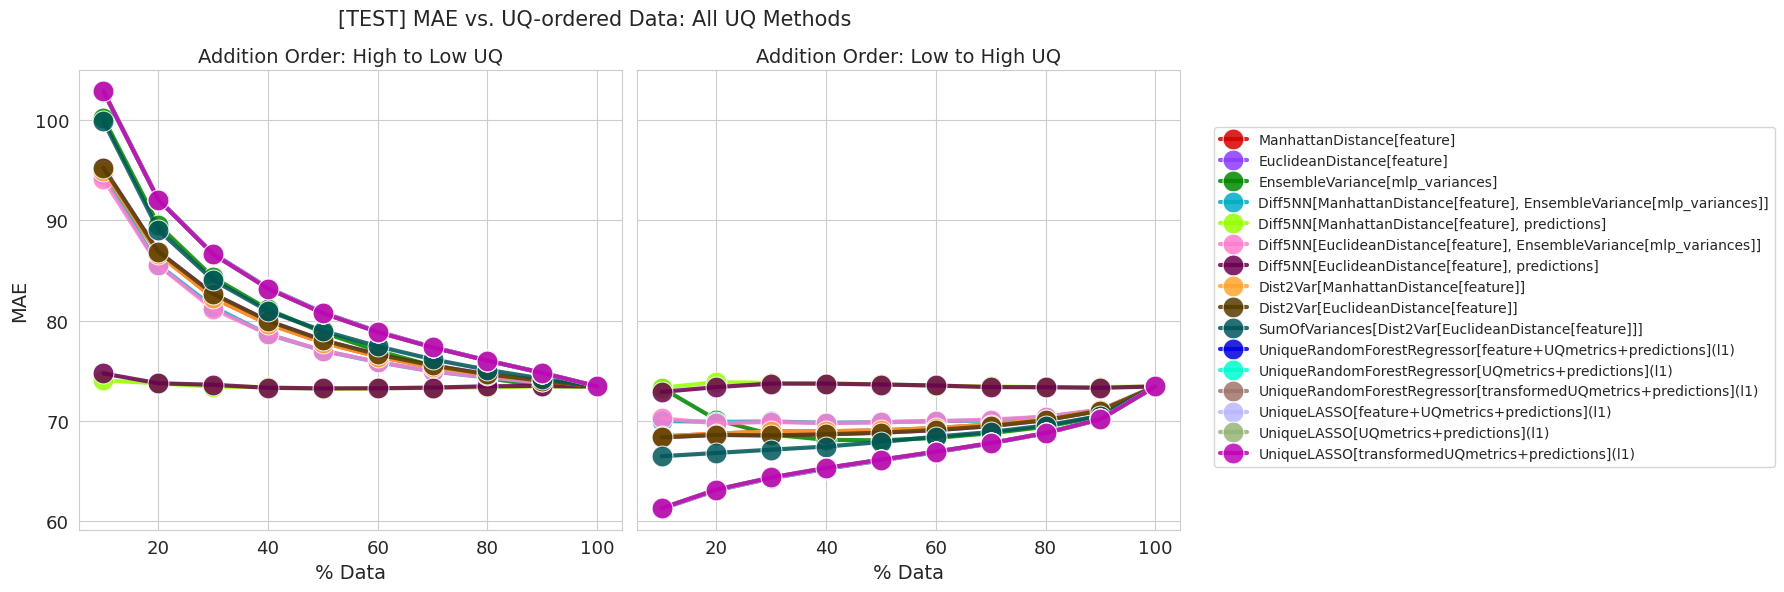

In [4]:
config_file = f'{PROJECT_PATH}/config_mlp.yaml'

# Replace `data_path` and `output_path` to be able run the notebook automatically
overwrite_paths(config_file, PROJECT_PATH) # COMMENT TO DISABLE OVERWRITING

pipeline = Pipeline.from_config(config_file)

# Compute UQ metrics, train error models (if any), evaluate UQ metrics
output, eval_results = pipeline.fit()

In [5]:
# Optionally save the computed UQ metrics
pd.DataFrame.from_dict(output).to_csv(pipeline.output_path / "uq_metrics_values.csv", index=False)

# `eval_results` is a dict containing the evaluation data used to generate the plots